In [ ]:
import matplotlib.pyplot as plt
from data_loader import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

In [6]:
bc = load_breast_cancer("breast-cancer", scaled=True)
X, y = bc["x"], bc["y"]

In [7]:
for i in range(9):
    print(X[0][i])

-0.111111
-1.0
-1.0
-1.0
-0.777778
-1.0
-0.555556
-1.0
-1.0


In [8]:
y[0]

np.int64(0)

In [9]:
X.shape

(683, 9)

In [11]:
# stratified split για να κρατησουμε το class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=0,
    stratify=y,
)
print(X_train.shape, X_test.shape)

(478, 9) (205, 9)


In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

def evaluate_svm(name, base_svc, param_grid):
    """
    Τρεχει GridSearchCV για ενα SVC και γυρναει dict με αποτελεσματα.
    """
    grid = GridSearchCV(
        estimator=base_svc,
        param_grid=param_grid,
        scoring="f1",      # μπορεις και "f1_macro" αν θες
        cv=cv,
        n_jobs=-1,
        verbose=0,
    )
    
    %time grid.fit(X_train, y_train)  # για να βλεπεις χρονο

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)

    print(f"\n=== {name} ===")
    print("Best params:", grid.best_params_)
    print(f"Test accuracy: {acc:.4f}")
    print(f"Test F1 score: {f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=["benign", "malignant"]))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    return {
        "name": name,
        "best_params": grid.best_params_,
        "cv_best_score": grid.best_score_,
        "test_accuracy": acc,
        "test_f1": f1,
    }


In [13]:
results = []

svc_linear = SVC(kernel="linear")

param_grid_linear = {
    "C": [0.01, 0.1, 1, 10, 100]
}

res_linear = evaluate_svm(
    "SVM_linear",
    svc_linear,
    param_grid_linear
)
results.append(res_linear)


CPU times: user 163 ms, sys: 509 ms, total: 672 ms
Wall time: 2.05 s

=== SVM_linear ===
Best params: {'C': 0.1}
Test accuracy: 0.9610
Test F1 score: 0.9444

Classification report:
              precision    recall  f1-score   support

      benign       0.97      0.97      0.97       133
   malignant       0.94      0.94      0.94        72

    accuracy                           0.96       205
   macro avg       0.96      0.96      0.96       205
weighted avg       0.96      0.96      0.96       205

Confusion matrix:
[[129   4]
 [  4  68]]


In [14]:
svc_rbf = SVC(kernel="rbf")

param_grid_rbf = {
    "C":     [0.1, 1, 10, 100, 1000],
    "gamma": ["scale", 0.01, 0.1, 1, 10]
}

res_rbf = evaluate_svm(
    "SVM_rbf",
    svc_rbf,
    param_grid_rbf
)
results.append(res_rbf)


CPU times: user 152 ms, sys: 20.5 ms, total: 172 ms
Wall time: 1.45 s

=== SVM_rbf ===
Best params: {'C': 10, 'gamma': 0.01}
Test accuracy: 0.9610
Test F1 score: 0.9444

Classification report:
              precision    recall  f1-score   support

      benign       0.97      0.97      0.97       133
   malignant       0.94      0.94      0.94        72

    accuracy                           0.96       205
   macro avg       0.96      0.96      0.96       205
weighted avg       0.96      0.96      0.96       205

Confusion matrix:
[[129   4]
 [  4  68]]


In [15]:
svc_poly = SVC(kernel="poly")

param_grid_poly = {
    "C":     [0.1, 1, 10, 100],
    "degree": [2, 3, 4],
    "gamma": ["scale", 0.1, 1],
    "coef0": [0.0, 1.0]
}

res_poly = evaluate_svm(
    "SVM_poly",
    svc_poly,
    param_grid_poly
)
results.append(res_poly)


CPU times: user 330 ms, sys: 16.8 ms, total: 347 ms
Wall time: 418 ms

=== SVM_poly ===
Best params: {'C': 0.1, 'coef0': 0.0, 'degree': 3, 'gamma': 'scale'}
Test accuracy: 0.9756
Test F1 score: 0.9660

Classification report:
              precision    recall  f1-score   support

      benign       0.99      0.97      0.98       133
   malignant       0.95      0.99      0.97        72

    accuracy                           0.98       205
   macro avg       0.97      0.98      0.97       205
weighted avg       0.98      0.98      0.98       205

Confusion matrix:
[[129   4]
 [  1  71]]


In [ ]:
df_results = pd.DataFrame(results)
display(df_results.sort_values("test_f1", ascending=False))


,name,best_params,cv_best_score,test_accuracy,test_f1
2,SVM_poly,"{'C': 0.1, 'coef0': 0.0, 'degree': 3, 'gamma':...",0.965462,0.975610,0.965986
0,SVM_linear,{'C': 0.1},0.964408,0.960976,0.944444
1,SVM_rbf,"{'C': 10, 'gamma': 0.01}",0.961604,0.960976,0.944444


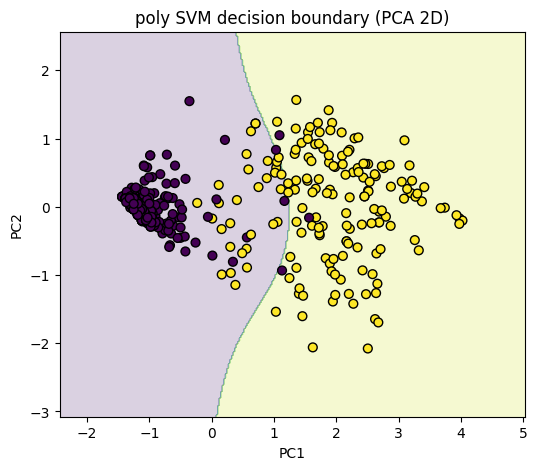

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d  = pca.transform(X_test)

svc_2d = SVC(kernel="poly", C=res_poly["best_params"]["C"],
             gamma=res_poly["best_params"]["gamma"])
svc_2d.fit(X_train_2d, y_train)

# grid για plotting
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)
Z = svc_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, Z, alpha=0.2)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, edgecolor="k", s=40)
plt.title("poly SVM decision boundary (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
